In [349]:
import torch
torch.__version__

'2.0.1+cu118'

In [350]:
from sklearn.datasets import make_blobs
import pandas as pd

X, y = make_blobs(n_samples=1000,
                  centers=4,
                  random_state=42,
                  cluster_std=1.5)

y.shape, X.shape

Dataframe = pd.DataFrame({"X1": X[:, 0],
                          "X2": X[:, 1],
                          "y": y})
Dataframe.head(5)

,X1,X2,y
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766102,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1


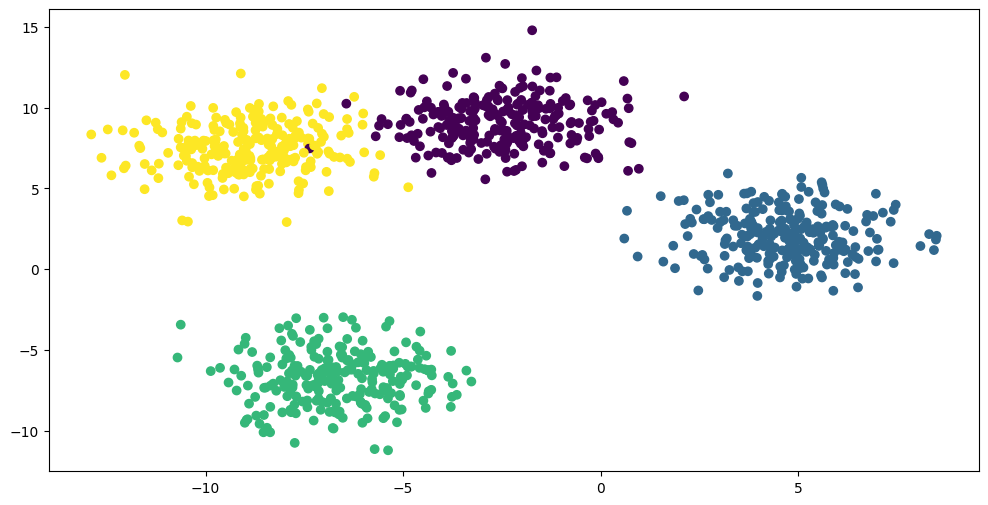

In [351]:
# Visvalizing the Dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], c=y)

In [352]:
# Splitting Data
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X.shape, X.dtype, type(X), X.device
len(X_train)

800

In [353]:
# Making Model
import torch.nn as nn

class ModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.layer_0 = nn.Linear(in_features=2, out_features=8)
        self.layer_1 = nn.Linear(in_features=8, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=4)

    def forward(self, x):
        return self.layer_2(self.layer_1(self.layer_0(x)))
    
model_0 = ModelV0().to(device)

model_0.eval()
with torch.inference_mode():
    y_init_pred = model_0(X_test)

y_init_pred[:10]

tensor([[ 1.5820,  0.2405,  0.7988,  0.3115],
        [ 0.0259,  0.1957, -0.2951,  0.1137],
        [ 0.1985,  0.1900, -0.4485,  0.1065],
        [ 0.0570,  0.1940, -0.3407,  0.1105],
        [ 1.3287,  0.2499,  1.0488,  0.3246],
        [-0.2851,  0.2323,  0.6572,  0.1983],
        [-0.3223,  0.2355,  0.7408,  0.2052],
        [-0.0916,  0.2439,  0.9487,  0.2393],
        [ 0.3130,  0.1819, -0.6601,  0.0901],
        [ 0.7953,  0.2492,  1.0513,  0.2969]], device='cuda:0')

In [354]:
y_init_pred_soft = torch.softmax(y_init_pred, dim=1)
y_init_pred_soft[:10]

tensor([[0.5002, 0.1308, 0.2286, 0.1404],
        [0.2499, 0.2961, 0.1813, 0.2728],
        [0.2918, 0.2893, 0.1528, 0.2661],
        [0.2582, 0.2961, 0.1734, 0.2723],
        [0.4061, 0.1381, 0.3070, 0.1488],
        [0.1457, 0.2444, 0.3738, 0.2362],
        [0.1363, 0.2381, 0.3946, 0.2310],
        [0.1510, 0.2112, 0.4274, 0.2103],
        [0.3273, 0.2871, 0.1237, 0.2619],
        [0.2875, 0.1665, 0.3714, 0.1746]], device='cuda:0')

In [355]:
torch.argmax(y_init_pred_soft, dim=1)

tensor([0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0,
        2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0,
        2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
        0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
        0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 0, 0,
        0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0,
        2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
        2, 0, 2, 0, 2, 0, 2, 2], device='cuda:0')

In [356]:
from torchmetrics import Accuracy

acc = Accuracy(task="multiclass", num_classes=4).to(device)

In [357]:
print(f"Initial Accuracy: {acc(torch.argmax(y_init_pred_soft, dim=1), y_test.int())}")

Initial Accuracy: 0.17000000178813934


In [358]:
import numpy as np

def plot_decision_boundry(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    
    # Make features

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make pred
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


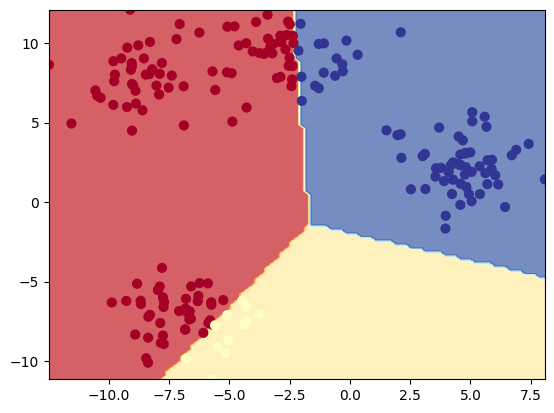

In [359]:
plot_decision_boundry(model_0, X_test, torch.argmax(y_init_pred_soft, dim=1))

In [360]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [361]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10_000

model_0.to(device)

for epoch in range(epochs):
    model_0.train()

    y_train_pred = model_0(X_train)
    y_train_pred_soft = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)

    loss = loss_fn(y_train_pred, y_train)
    acc_train = acc(y_train_pred_soft, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(X_test)

        y_test_pred_sig = torch.argmax(torch.softmax(y_test_pred, dim=1), dim=1)

        acc_test = acc(y_test_pred_sig, y_test)

    if epoch % 100 == 0:
        print(f"EPOCH: {epoch} | Accuracy Train: {acc_train} | Accuracy Test: {acc_test}")

EPOCH: 0 | Accuracy Train: 0.14499999582767487 | Accuracy Test: 0.25999999046325684


EPOCH: 100 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9750000238418579
EPOCH: 200 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 300 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 400 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 500 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 600 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 700 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 800 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 900 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 1000 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 1100 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.9800000190734863
EPOCH: 1200 | Accuracy Train: 0.9950000047683716 | Accuracy Test: 0.980000

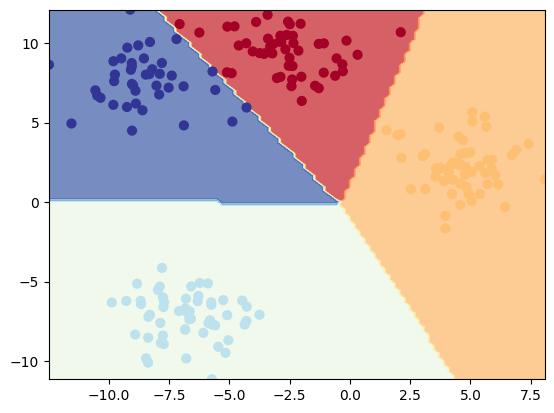

In [366]:
model_0.eval()
with torch.inference_mode():
    y_test_preds = model_0(X_test)
    y_test_preds_soft = torch.argmax(torch.softmax(y_test_pred, dim=1), dim=1)

plot_decision_boundry(model_0, X_test, y_test_preds_soft)